In [1]:
%cd '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/scripts'
base_path = '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/'

/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/scripts


In [2]:
import re
import glob
import ast
import shap
import scipy.stats as st
from collections import Counter
import sklearn
from matplotlib import cm
import scipy
import itertools
from datetime import datetime
from seaborn import clustermap
from scipy.cluster.hierarchy import linkage
from sklearn.linear_model import LogisticRegression
import os
import time
import pickle as pkl

from helper import *
from dataLoader import *

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

# Get AUCs and coefficients for all models in given folder

In [3]:
use_seeds = False
move_csvs = False
path = '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/'
path2 = '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/'
# path = 'out_test/'
# path = 'LR_local/may18_ba_metabs/'
with open(path + 'aucs.pkl', 'rb') as f:
    auc_all = pkl.load(f)
    
for method in os.listdir(path):
    in_path = path + method + '/'
#     if len(method.split('_'))==2:
#         continue
    if not os.path.isdir(in_path):
        continue
        
    if method in auc_all.keys():
        ls = list(auc_all['cox2_week1.0'].keys())
        ls.remove('demo')
        if len(ls)>=5:
            for folder in os.listdir(in_path):
                if not os.path.isdir(in_path +  folder):
                    continue
                if len(os.listdir(in_path + folder)) == 0:
                    continue
                if 'coefs.csv' not in os.listdir(in_path + folder):
                    get_coefs(in_path, folder)
                    print('coefs in ' + in_path + folder)
            continue
        else:
            print(method)
            print(set(auc_all[method].keys()))
    if 'DS' in method:
        continue

    final_res_dict = {}
    
    for folder in os.listdir(in_path):
        if not os.path.isdir(in_path  + folder):
            continue
        final_res_dict[folder] = {}
        for file in os.listdir(in_path + folder):
            if 'pkl' not in file:
                continue
            if file == '.DS_Store':
                continue
            try:
                with open(in_path + folder + '/' + file, 'rb') as f:
                        # temp is a dictionary with parameter keys 
                    temp = pkl.load(f)
            except:
                print('PICKLE ERROR')
                print(in_path + folder + '/' + file)
                break
            try:
                ix = int(file.split('_')[-1].split('.')[0])
            except:
                final_res_dict[folder] = temp

            if use_seeds:
                seed = int(file.split('_')[-2])
                if ix not in final_res_dict[folder].keys():
                    final_res_dict[folder][ix] = {}
                if seed not in final_res_dict[folder][ix].keys():
                    final_res_dict[folder][ix][seed] = {}

                final_res_dict[folder][ix][seed] = temp
            else:
                final_res_dict[folder][ix] = temp

    auc_dict = get_auc_df(final_res_dict, in_path )
    auc_all[method] = auc_dict
    print('performance results in ' + in_path)
    
    for folder in os.listdir(in_path):
        if not os.path.isdir(in_path +  folder):
            continue
        if len(os.listdir(in_path + folder)) == 0:
            continue
        if 'coefs.csv' not in os.listdir(in_path + folder):
            get_coefs(in_path, folder)
            print('coefs in ' + in_path + folder)
    
with open(path + 'aucs.pkl', 'wb') as f:
    pkl.dump(auc_all, f)

/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/cox2_week1.0/scfa
coefs in /Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/cox2_week1.0/scfa
/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/cox2_week1.0/demo
coefs in /Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/cox2_week1.0/demo
/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/cox2_week1.0/16s
coefs in /Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/cox2_week1.0/16s
/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/cox2_week1.0/metabs
coefs in /Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/cox2_week1.0/metabs
/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/cox2_week1.0/metabs_16s_sc

coefs in /Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/RF_week1.0/demo
/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/RF_week1.0/16s
coefs in /Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/RF_week1.0/16s
/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/RF_week1.0/metabs
coefs in /Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/RF_week1.0/metabs
/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/RF_week1.0/metabs_16s_scfa_toxin_demo
coefs in /Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/RF_week1.0/metabs_16s_scfa_toxin_demo
/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/RF_week1.0/toxin
coefs in /Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnal

In [8]:
path = base_path + 'PredictiveAnalysisResults/'

with open(path + 'aucs.pkl', 'rb') as f:
    auc_all = pkl.load(f)

In [4]:
from string import ascii_uppercase
path_save = '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Supplemental Tables/'
path2 = '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/'

out_dict = {}
data_dict = {}
i=0
for key in auc_all.keys():
    keyl = key.split('_')
    if len(keyl)>2:
        continue
    for kk in auc_all[key].keys():
        keyl.append(kk.replace('_','+'))
        temp = auc_all[key][kk].copy()
        sc = pd.DataFrame(temp['data'])
        temp_dat = np.empty(48)
        temp_dat[:] = np.nan
        temp_dat[np.arange(len(sc))] = sc.values.squeeze()
        data_dict[tuple(keyl)] = temp_dat
        del temp['data']
        out_dict[tuple(keyl)] = temp
        keyl.pop(-1)
        i += 1
df_dat = pd.DataFrame(data_dict).T.sort_index().T
df = pd.DataFrame(out_dict).T
df = df.sort_index()
path_save = '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Supplemental Tables/'
with pd.ExcelWriter(path_save + 'Table 4. Predictive Results.xlsx', mode = 'w') as writer:
    df.to_excel(writer, sheet_name = 'A. Results')
    
    
with pd.ExcelWriter(path_save + 'Table 4. Predictive Results.xlsx', mode = 'a') as writer:
    df_dat.to_excel(writer, sheet_name = 'B. Data')

## Move & rename csvs

In [4]:
path2 = '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/'
path = 'PredictiveAnalysisResults/'

for method in os.listdir(path2 + path):
    if 'DS' in method:
        continue
    in_path = path2 + path + method + '/'

    if not os.path.isdir(in_path):
        continue
    auc_dict = auc_all[method]
    coef_res_dict = {}
    for folder in os.listdir(in_path):
        print(in_path + folder)
        if not os.path.isdir(in_path +  folder):
            continue
        csv_files = glob.glob(os.path.join(in_path + folder, '*.csv'))
        if len(csv_files)>0:
            for csv_file in csv_files:
                if len(method.split('_')) == 5:
                    nm = 'joint'
                else:
                    nm = method.split('_')[1]
                new_dir = path2 + 'predictive_feature_tables/' + folder + '_' + nm+ '/'
#                 print(new_dir)
                if not os.path.isdir(new_dir):
                    os.mkdir(new_dir)
                os.rename(csv_file, new_dir + method.split('_')[0] + '-' + 
                          str(np.round(auc_dict[folder]['Median'], 3)).replace('.','')[:4] + '.csv')

/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/cox2_week1.0/scfa
/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/cox2_week1.0/demo
/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/cox2_week1.0/16s
/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/cox2_week1.0/.DS_Store
/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/cox2_week1.0/scfa.txt
/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/cox2_week1.0/16s.txt
/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/cox2_week1.0/metabs
/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/cox2_week1.0/metabs_16s_scfa_toxin_demo
/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/PredictiveAnalysisResults/cox2_week1.0/toxin
/Users/jen

In [6]:
from string import ascii_uppercase
path_save = '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Supplemental Tables/'
path2 = '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/'
taxa_labels = pd.read_csv(path2 + 'scripts/inputs/' + 'taxa_labels.csv', index_col = [0])

ii = 5
idict = {}
tname = {}
df_out = {}
for folder in os.listdir(path2 + 'predictive_feature_tables/'):
    fname = '-'.join(folder.split('_')[:-1])
    if folder == '.DS_Store':
        continue
    if 'slope' in folder:
        continue
    if fname not in tname.keys():
        ii += 1
        tname[fname]  = ii
#     print(tname)
    if fname not in df_out.keys():
        df_out[fname] = {}
    table_name = path_save + 'Table ' + str(tname[fname]) + ' - ' + fname.capitalize() + ' Predictive Analysis.xlsx'
    timepoint = folder.split('_')[-1].capitalize()
    for file in os.listdir(path2 + 'predictive_feature_tables/' + folder):
        if file == '.DS_Store':
            continue
        sigfeats = pd.read_csv(path2 + 'predictive_feature_tables/' + folder + '/' + file, index_col = 0)
        
        label = file.split('.')[0] + ' ' + timepoint
        
        sigfeats = sigfeats.loc[sigfeats.iloc[:,0]!=1, :]
        
        
        if '16s' in fname:
            seqs = list(set(sigfeats.index.values).intersection(taxa_labels['taxa_rdp'].index.values))
            sigfeats['Taxonomy-RDP'] = np.zeros(len(sigfeats.index.values))
#             sequences = sigfeats.index.values
            sigfeats['Taxonomy-RDP'].loc[seqs] = taxa_labels['taxa_rdp'].loc[seqs]
#             sigfeats['Taxonomy-Silva'] = taxa_labels['taxa_silva'].loc[sigfeats.index.values]
            sigfeats['Labels'] = sigfeats.index.values
            sigfeats['Labels'].loc[seqs] = taxa_labels['labels'].loc[seqs]
            sigfeats = sigfeats.set_index('Labels')
#             sigfeats['Sequences'] = sequences
            
        for ix in sigfeats.index.values:
            df_out[fname][(label.split(' ')[1], label.split(' ')[0], ix)] = sigfeats.loc[ix].to_dict()
            
for f in df_out.keys():
    df = pd.DataFrame(df_out[f]).T.sort_index()
    if os.path.exists(path_save + 'Table 5. Predictive Features.xlsx'):
        with pd.ExcelWriter(path_save + 'Table 5. Predictive Features.xlsx',mode ='a') as writer:
            df.to_excel(writer, sheet_name = f)
            
    else:
        with pd.ExcelWriter(path_save + 'Table 5. Predictive Features.xlsx') as writer:
            df.to_excel(writer, sheet_name = f)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [9]:
from string import ascii_uppercase
path_save = '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Data/Predictive Analyses/'
path2 = '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/'
taxa_labels = pd.read_csv(path2 + 'scripts/inputs/' + 'taxa_labels.csv', index_col = [0])

ii = 5
idict = {}
tname = {}
df_out = {}
for folder in os.listdir(path2 + 'predictive_feature_tables/'):
    fname = '-'.join(folder.split('_')[:-1])
    df_out[fname] = {}
    if folder == '.DS_Store':
        continue
    if fname not in tname.keys():
        ii += 1
        tname[fname]  = ii
#     print(tname)
    table_name = path_save + 'Table ' + str(tname[fname]) + ' - ' + fname.capitalize() + ' Predictive Analysis.xlsx'
    timepoint = folder.split('_')[-1].capitalize()
    for file in os.listdir(path2 + 'predictive_feature_tables/' + folder):
        if file == '.DS_Store':
            continue
        sigfeats = pd.read_csv(path2 + 'predictive_feature_tables/' + folder + '/' + file, index_col = 0)
        
        label = file.split('.')[0] + ' ' + timepoint
        
        if '16s' in fname:
            seqs = list(set(sigfeats.index.values).intersection(taxa_labels['taxa_rdp'].index.values))
            sigfeats['Taxonomy-RDP'] = np.zeros(len(sigfeats.index.values))
#             sequences = sigfeats.index.values
            sigfeats['Taxonomy-RDP'].loc[seqs] = taxa_labels['taxa_rdp'].loc[seqs]
#             sigfeats['Taxonomy-Silva'] = taxa_labels['taxa_silva'].loc[sigfeats.index.values]
            sigfeats['Labels'] = sigfeats.index.values
            sigfeats['Labels'].loc[seqs] = taxa_labels['labels'].loc[seqs]
            sigfeats = sigfeats.set_index('Labels')
#             sigfeats['Sequences'] = sequences
            
        for ix in sigfeats.index.values:
            df_out[fname][(label, ix)] = sigfeats.loc[ix].to_dict()
        
        if table_name not in idict and os.path.exists(table_name):
            os.remove(table_name)
        if os.path.exists(table_name):
            idict[table_name] += 1
            nm = ascii_uppercase[idict[table_name]]
            with pd.ExcelWriter(table_name, mode = 'a') as writer:
                sigfeats.to_excel(writer, sheet_name = nm + '.' + label)
        else:
            idict[table_name] = 0
            nm = ascii_uppercase[idict[table_name]]
            with pd.ExcelWriter(table_name) as writer:
                sigfeats.to_excel(writer, sheet_name = nm + '.' + label)

In [10]:
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Ellipse, Rectangle

# define an object that will be used by the legend
class MulticolorPatch(object):
    def __init__(self, colors):
        self.colors = colors
        
# define a handler for the MulticolorPatch object
class MulticolorPatchHandler(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        handlebox.width = handlebox.height*len(orig_handle.colors) + 0.1*handlebox.height*len(orig_handle.colors)
        width, height = handlebox.width, handlebox.height
        patches = []
        for i, c in enumerate(orig_handle.colors):
            patches.append(Rectangle([width/len(orig_handle.colors)*i + (handlebox.height*0.1)*i, 0],
                           height,
                           height, 
                           facecolor=c, 
                           edgecolor='gray'))           

        patch = PatchCollection(patches,match_original=True)

        handlebox.add_artist(patch)
        return patch

In [8]:
auc_split = {}
for k, v in auc_all.items():
    method, week = k.split('_week')
    if week not in auc_split.keys():
        auc_split[week] = {}
    for kk, vv in v.items():
        if len(kk.split('_'))==5:
            kk = 'joint'
        if kk not in auc_split[week].keys():
            auc_split[week][kk] = {}
        auc_split[week][kk][method] = vv

In [9]:
def get_panal_locs(ax):
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    return (xmin,ymax + 0.1*(ymax-ymin))

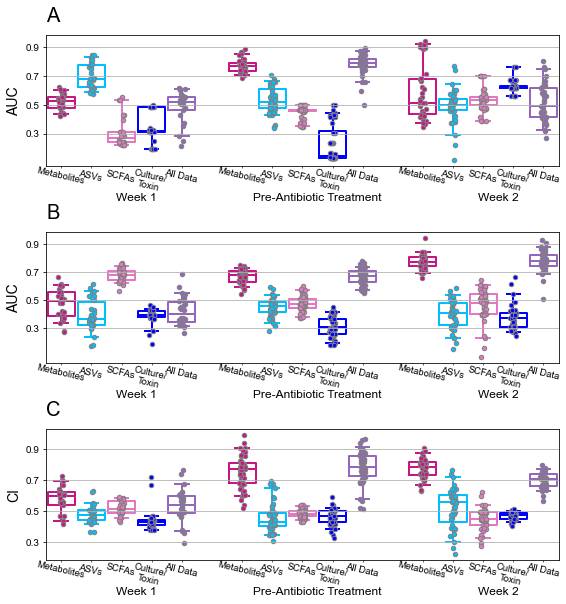

In [11]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

fig, ax = plt.subplots(3,1,figsize = (8,8.5))

cmap = plt.get_cmap('tab20')
# fig, ax = plt.subplots(figsize = (14,5))
i=0
p={}
k = 0
j = 0
colors = {'metabs':'mediumvioletred','scfa':'tab:pink','16s':'deepskyblue','toxin':'blue','joint':'tab:purple'}
out_colors = {}
xmaj = []
xstart = -2
xmin = []
for i,model in enumerate(['LR','RF','cox2']):
    xminor = []
    xmajor = []
    for week in auc_split.keys():
        for k, dattype in enumerate(['metabs','16s','scfa','toxin','joint']):
            xloc = float(week)*5 + k + float(week)
            dat = auc_split[week][dattype][model]['data']
            p = ax[i].boxplot(dat, positions = [xloc], widths = 0.9,whis=[5, 95],showfliers=False)
            for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
                plt.setp(p[element], color=colors[dattype], linewidth = 2, alpha = 1, zorder = -1)
                
            ax[i].scatter([xloc]*len(dat) + np.random.uniform(-1,1, size = len(dat))*.1, dat, 
                          marker = 'o', color = colors[dattype],edgecolors = 'gray', s = 20)
            
            xminor.append(xloc)
        xmajor.append(float(week)*5 + float(week) + 2.5)
        
    ax[i].set_yticks([0.3,0.5,0.7,0.9])
    ax[i].set_yticklabels([0.3,0.5,0.7,0.9],fontsize = 10)
    if model != 'cox2':
        ax[i].set_ylabel('AUC', fontsize = 14)
    else:
        ax[i].set_ylabel('CI', fontsize = 14)

    ax[i].set_xticks(xmajor)
    ax[i].set_xticklabels(['\n\nPre-Antibiotic Treatment', '\n\nWeek 1', '\n\nWeek 2'], fontsize = 12)
    #                     '\n\nChange from \nweek 1 to 2'], fontsize = 16)
    ax[i].set_xticks(xminor, minor = True)

    ax[i].set_xticklabels(['Metabolites', 'ASVs', 'SCFAs', 'Culture/\nToxin','All Data','Metabolites','ASVs', 
                    'SCFAs', 'Culture/\nToxin','All Data','Metabolites', 'ASVs', 'SCFAs', 'Culture/\nToxin','All Data'
    #                      ,'Metabolites','ASVs', 'SCFAs', 'Culture/\nToxin'
                    ], minor = True, fontsize = 9.5, 
                    rotation = -13, rotation_mode = 'anchor', ha = 'center')
    
    ax[i].grid(axis='y')
    ax[i].tick_params(axis=u'x', which=u'major',length=0)
    ax[i].tick_params(axis=u'x', which=u'minor',length=2)
    
xy_e = get_panal_locs(ax[0])
ax[0].annotate('A', xy = xy_e, annotation_clip = False, fontsize =20)

xy_e = get_panal_locs(ax[1])
ax[1].annotate('B', xy = xy_e, annotation_clip = False, fontsize = 20)

xy_e = get_panal_locs(ax[2])
ax[2].annotate('C', xy = xy_e, annotation_clip = False, fontsize = 20)


fig.tight_layout()
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.5)
fig.savefig('/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/Fig4/fig4_oct12.pdf')

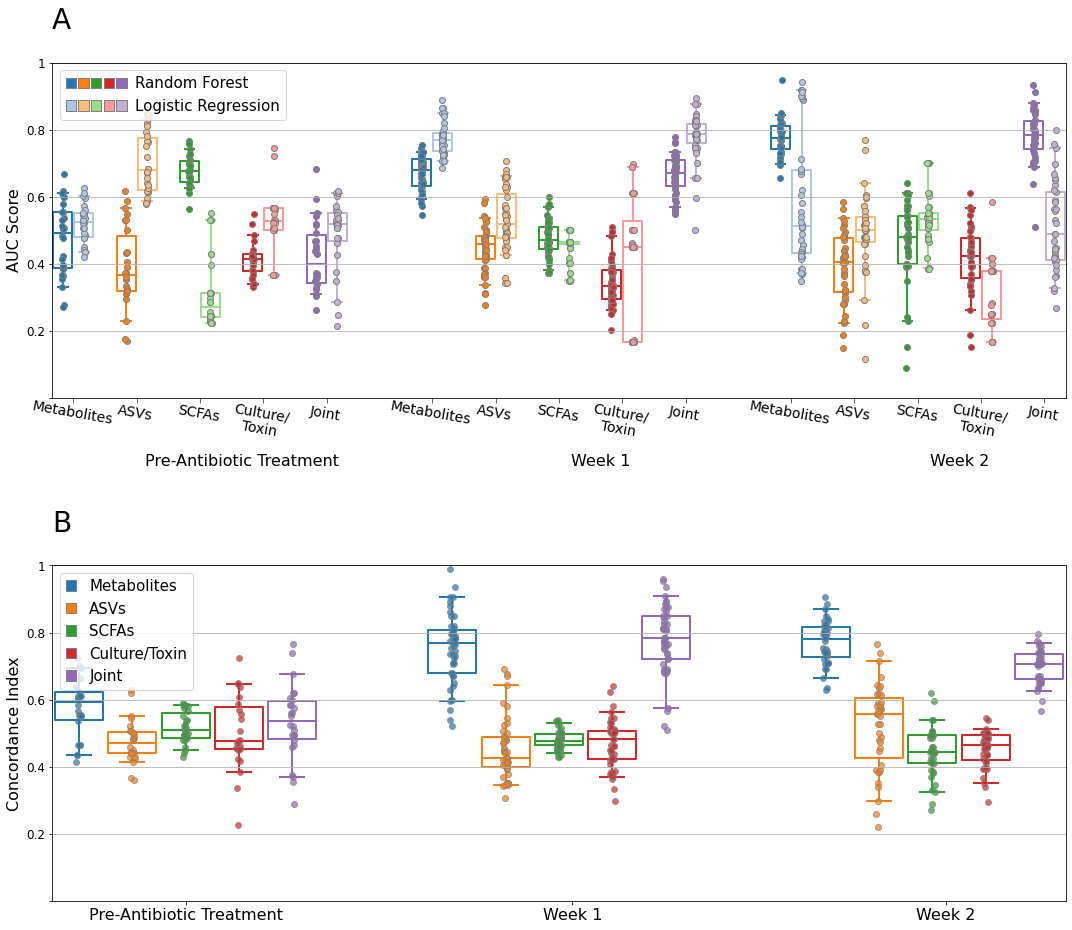

In [42]:
fig, ax_both = plt.subplots(2,1,figsize = (15,13))
ax1 = ax_both[0]
ax2 = ax_both[1]

cmap = plt.get_cmap('tab20')
# fig, ax = plt.subplots(figsize = (14,5))
x = {'0.0': {'metabs': ['RF', 'LR'], '16s': ['RF', 'LR'], 'scfa': ['RF', 'LR'],'toxin': ['RF', 'LR'],'joint':['RF','LR']}, 
     '1.0': {'metabs': ['RF', 'LR'], '16s': ['RF', 'LR'], 'scfa': ['RF', 'LR'], 'toxin': ['RF', 'LR'],'joint':['RF','LR']}, 
     '2.0': {'metabs': ['RF', 'LR'], '16s': ['RF', 'LR'], 'scfa': ['RF', 'LR'], 'toxin': ['RF', 'LR'],'joint':['RF','LR']}}
#     '1_1a5_2': {'metabs': ['RF', 'LR'], '16s': ['RF', 'LR'], 'scfa': ['RF', 'LR'], 'toxin': ['RF', 'LR']}}
i=0
p={}
k = 0
j = 0
cvec = {'RF':'g','LR':'b'}
out_colors = {}
xmaj = []
xstart = -2
xmin = []
for week in x.keys():
    for dtype in x[week].keys():
        out_colors[dtype] = {}
        for method in x[week][dtype]:
            y = auc_split[week][dtype][method]['data']
#             yerr = np.array([ast.literal_eval(auc_split[week][dtype][method]['MAD Interval'])]).T
#             yerr[yerr>1] = 1
#             temp = yerr.copy()
#             temp[0,:] = abs(yerr[1,:] - y[0])
#             temp[1,:] = abs(yerr[0,:] - y[0])
#             p[i] = ax1.bar([i], y, yerr = temp, color = cmap(k))
            p[i] = ax1.boxplot(y, positions = [i], widths = 0.9,whis=[5, 95],showfliers=False)
            for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
                plt.setp(p[i][element], color=cmap(k), linewidth = 2, alpha = 1, zorder = -1)
            out_colors[dtype][method] = cmap(k)
            ax1.scatter([i]*len(y) + np.random.uniform(-1,1, size = len(y))*.05, y, marker = 'o', color = cmap(k),
                       edgecolors = 'gray')
            k += 1
            i+= 1
#             k += 4

        xmin.append(i-1.5)
        i += 1
        j += 1
#         k = j
    i += 2
    k=0
    j=0
    xmaj.append(xmin[-2] - 1)
    xstart = i-1.5
ax1.set_ylim([0,1])

h=[]
l=[]
for k in out_colors['metabs'].keys():
    h.append(MulticolorPatch([out_colors[d][k] for d in x[week].keys()]))
    if k == 'RF':
        k = 'Random Forest'
    if k == 'LR':
        k = 'Logistic Regression'
    l.append(k)

leg2 = ax1.legend(h, l, 
           handler_map={MulticolorPatch: MulticolorPatchHandler()}, loc = 'upper left', 
                 #bbox_to_anchor=(.9, 0.79),
                 prop={'size': 15})
ax1.set_yticks([0,.2,.4,.6,.8,1])
ax1.set_yticklabels(['',.2,.4,.6,.8,1],fontsize = 12)
ax1.set_ylabel('AUC Score', fontsize = 16)

ax1.set_xticks(xmaj)
ax1.set_xticklabels(['\n\n\nPre-Antibiotic Treatment', '\n\n\nWeek 1', '\n\n\nWeek 2'], fontsize = 16)
#                     '\n\nChange from \nweek 1 to 2'], fontsize = 16)
ax1.set_xticks(xmin, minor = True)

ax1.set_xticklabels(['Metabolites', 'ASVs', 'SCFAs', 'Culture/\nToxin','Joint','Metabolites','ASVs', 
                    'SCFAs', 'Culture/\nToxin','Joint','Metabolites', 'ASVs', 'SCFAs', 'Culture/\nToxin','Joint'
#                      ,'Metabolites','ASVs', 'SCFAs', 'Culture/\nToxin'
                    ], minor = True, fontsize = 14, 
                    rotation = -10, rotation_mode = 'anchor', ha = 'center')
ax1.grid(axis='y')
ax1.tick_params(axis=u'x', which=u'major',length=0)
ax1.tick_params(axis=u'x', which=u'minor',length=5)



cmap = plt.get_cmap('tab10')

x = {'0.0': {'metabs': ['cox2'], '16s': ['cox2'], 'scfa': ['cox2'], 'toxin': ['cox2'],'joint':['cox2']}, 
     '1.0': {'metabs': ['cox2'], '16s': ['cox2'], 'scfa': ['cox2'], 'toxin': ['cox2'],'joint':['cox2']}, 
     '2.0': {'metabs': ['cox2'], '16s': ['cox2'], 'scfa': ['cox2'], 'toxin': ['cox2'],'joint':['cox2']}}
#     '1_1a5_2': {'metabs': ['cox2'], '16s': ['cox2'], 'scfa': ['cox2'], 'toxin': ['cox2']}}
i=0
p={}
k = 0
cvec = {'RF':'g','LR':'b'}
out_colors = {}
xmaj = []
xstart = -2
xmin = []
for week in x.keys():
    for dtype in x[week].keys():
        out_colors[dtype] = {}
        for method in x[week][dtype]:
            y = auc_split[week][dtype][method]['data']

            p[i] = ax2.boxplot(y, positions = [i], widths = 0.9,whis=[5, 95],showfliers=False)
            for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
                plt.setp(p[i][element], color=cmap(k), linewidth = 2, alpha = 1, zorder = -1)
            out_colors[dtype][method] = cmap(k)
            ax2.scatter([i]*len(y) + np.random.uniform(-1,1, size = len(y))*.05, y, marker = 'o', color = cmap(k),
                       edgecolors = 'gray', alpha = 0.7)
            i+= 1
#         k += 4
        k += 1
    xmaj.append((i + xstart)/2 + 0.5)
    i += 2
    k=0
    xstart = i-1.5
ax2.set_ylim([0,1])

h=[]
l=[]
for k in out_colors.keys():
    h.append(MulticolorPatch([out_colors[k][d] for d in x[week][k]]))
    if k == 'metabs':
        k = 'Metabolites'
    if k == '16s':
        k = 'ASVs'
    if k == 'scfa':
        k= 'SCFAs'
    if k == 'toxin':
        k = 'Culture/Toxin'
    if k == 'joint':
        k = 'Joint'
    l.append(k)

leg1 = ax2.legend(h, l, 
           handler_map={MulticolorPatch: MulticolorPatchHandler()}, loc = 'upper left', 
                  #bbox_to_anchor=(.9, .76),
                 prop={'size': 15})

ax2.set_yticks([0,.2,.4,.6,.8,1])
ax2.set_yticklabels(['',.2,.4,.6,.8,1],fontsize = 12)
ax2.set_ylabel('Concordance Index', fontsize = 16)

ax2.set_xticks(xmaj)
ax2.set_xticklabels(['Pre-Antibiotic Treatment', 'Week 1', 'Week 2'
#                      ,'Change from \nweek 1 to 2'
                    ], fontsize = 16)


xy_e = get_panal_locs(ax1)
ax1.annotate('A', xy = xy_e, annotation_clip = False, fontsize = 28)

xy_b = get_panal_locs(ax2)
ax2.annotate('B', xy = xy_b, annotation_clip = False, fontsize = 28)
ax2.grid(axis='y')

fig.tight_layout()
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.5)
fig.savefig('/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/Fig4/fig4.pdf')

# Look at saved RF models to determine direction of effect

In [3]:
path = '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/RF_saved_model/'
path2 = path + 'RF_week2/metabs_16s_scfa_toxin_demo/'
file = 'coef_ix_0.pkl'
os.listdir(path2)

with open(path2 + '/' + file, 'rb') as f:
        # temp is a dictionary with parameter keys 
    temp = pkl.load(f)

vals_dict = {}
for seed in temp['models_out'].keys():
    model = temp['models_out'][seed]
    if isinstance(temp['data'][0], list):
        XX = pd.DataFrame(np.hstack(temp['data'][0]), columns = 
                         np.concatenate([x.columns.values for x in temp['data'][0]]))
        X = XX[temp['coefs_out'][seed]]
    else:
        X = temp['data'][0][temp['coefs_out'][seed]]
    y = temp['data'][1]
    explainer = shap.Explainer(model)
    shape_values = explainer(X)
    shape_vals = np.zeros((XX.shape[0], XX.shape[1], 2))
    sv_pd0 = pd.DataFrame(shape_vals[:,:,0], columns = XX.columns.values)
    sv_pd0[temp['coefs_out'][seed]] = shape_values.values[:,:,0]
    sv_pd1 = pd.DataFrame(shape_vals[:,:,1], columns = XX.columns.values)
    sv_pd1[temp['coefs_out'][seed]] = shape_values.values[:,:,1]
    shap_vals = np.stack((sv_pd0, sv_pd1), axis = 2)
#     ixs = [np.where(col_name == XX.columns.values)[0].item() for col_name in X.columns.values]
#     shap_vals[temp['coefs_out'][seed]] = shap_values.values[:,:,1]
    base_vals = shap_values.base_values
    coefs = model.feature_importances_
    coefs_all = pd.Series(np.zeros(XX.shape[1]),index = XX.columns.values)
    coefs_all[X.columns.values] = coefs
    vals_dict[seed] = {'X': X, 'Y': y, 'values': shap_vals, 'base': base_vals,
                       'data': shap_values.data, 'coefs': coefs_all}

    
med_coefs = np.median(np.stack([vals_dict[i]['coefs'] for i in temp['models_out'].keys()]), axis = 0)
med_vals = np.median(np.stack([vals_dict[i]['values'] for i in temp['models_out'].keys()]), axis = 0)
ix_nzero = np.where(med_coefs!= 0)[0]
nzero_vals = med_vals[:,ix_nzero,:]

for coef_ix in ix_nzero:
    coef_name = XX.columns.values[coef_ix]
    recurrers = np.where(y==1)[0]
    non_recurrers = np.where(y==0)[0]
    vals_recurrers = XX.iloc[recurrers, coef_ix]
    vals_non_recurrers = XX.iloc[non_recurrers, coef_ix]
    risk_re = med_vals[recurrers,coef_ix,1]
    risk_non = med_vals[non_recurrers,coef_ix,1]
    plt.figure()
    plt.title(coef_name)
    plt.scatter(vals_recurrers, risk_re, c = 'r', label = 'Recurrers')
    plt.scatter(vals_non_recurrers, risk_non, c= 'g', label = 'Non-recurrers')
    plt.xlabel(coef_name)
    plt.ylabel('Risk')
    plt.legend()
    plt.show()

NameError: name 'shap_values' is not defined